### Framingham_CHD_preprocessed_data
https://www.kaggle.com/datasets/captainozlem/framingham-chd-preprocessed-data 에서 가져온 데이터입니다.

Demographic:
• Sex: male or female(Nominal)
• Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

Behavioral
• Education: 0: Less than High School and High School degrees, 1: College Degree and Higher
• Current Smoker: whether or not the patient is a current smoker (Nominal)
• Cigs Per Day: the number of cigarettes that the person smoked on average in one day. (can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

Medical(history)
• BP Meds: whether or not the patient was on blood pressure medication (Nominal)
• Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)
• Prevalent Hyp: whether or not the patient was hypertensive (Nominal)
• Diabetes: whether or not the patient had diabetes (Nominal)

Medical(current)
• Tot Chol: total cholesterol level (Continuous)
• Sys BP: systolic blood pressure (Continuous)
• Dia BP: diastolic blood pressure (Continuous)
• BMI: Body Mass Index (Continuous)
• Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)
• Glucose: glucose level (Continuous)

Predict variable (desired target)
• 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)

1. "여러분이 풀고자 하는 문제를 잘 설정하였는가?"
- Framingham_CHD_preprocessed_data는 10년간의 심장병 가능성 혹은 병증 존재 여부를 타겟으로 15가지의 특성을 고려합니다. 15가지 항목값을 인풋하면 10년안에 심장병이 올 가능성에 대해 진단을 해주는 간략한 프로그램을 만든다고 보시면되겠습니다. 이것이 명목상의 개발 근거이나, 실제로는 xgboost와 딥러닝 간의 성능차이, 신경망 노드수와 레이어 간의 차이를 알아보고자 작성하였습니다. xgboost estimator 2000과, 90 * 1레이어, 45 * 2레이어, 30 * 3레이어 각 에폭 20 간의 차이를 분석할 것입니다.

2. "문제를 풀기 위한 모델 선택을 알맞게 설정하였는가?"
- 15개 정도의 특성을 다루는 간단한 xgboost머신러닝 모델 혹은 간단한 신경망 구조입니다. 문제 자체가 많은 변수를 다루지 않아 nlp나 cv처럼 복잡한 모델이 들어갈 수 없었습니다. 다만 최대한 튀는 값을 줄이기 위해 stratified한 데이터셋으로 모델을 사용하였습니다.

3. "모델 학습을 제대로 진행하였는가?"
- 전처리가 거의 되어있는 데이터셋으로 진행하였기 때문에 특별히 할게 없었습니다. 패러미터는 일반적으로 넣는 값에서 조금 정교하거나 혹은 과적합이 일어날 수 있는 값을 사용했습니다.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_origin = pd.read_csv('data/CHD_preprocessed.csv')
df_origin

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,1,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4128,1,50,0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4129,1,51,1,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4130,0,48,0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4131,0,44,0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,82.0,0


In [3]:
target = 'TenYearCHD'
df_origin[target].value_counts()
#85대 15비율

0    3505
1     628
Name: TenYearCHD, dtype: int64

In [4]:
df_origin.isna().any(axis=1).value_counts()

False    4133
dtype: int64

In [5]:
df_origin.duplicated().value_counts()

False    4133
dtype: int64

In [6]:
#상관계수를 알아보고 가설을 세우기 전에 일단 (train, val)[이상 nonTest], test 셋으로 나눕니다.
from sklearn.model_selection import train_test_split

df_nonTest, df_test = train_test_split(df_origin, test_size= 0.2, random_state=42, stratify=df_origin[target])
df_nonTest.corr().sort_values(target)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
education,0.007896,-0.083624,1.000000,-0.009661,-0.012143,-0.018426,-0.027600,-0.053647,-0.026187,-0.009107,-0.098666,-0.050535,-0.106785,-0.057869,-0.023268,-0.027642
currentSmoker,0.186474,-0.209292,-0.009661,1.000000,0.772066,-0.058672,-0.040169,-0.106239,-0.041377,-0.066791,-0.129491,-0.112964,-0.171327,0.054301,-0.051770,0.012119
heartRate,-0.115695,0.003339,-0.057869,0.054301,0.064937,0.031348,-0.007438,0.158807,0.058111,0.096653,0.194802,0.184715,0.078611,1.000000,0.098234,0.030611
cigsPerDay,0.319310,-0.198508,-0.012143,0.772066,1.000000,-0.051642,-0.037350,-0.069791,-0.028973,-0.048612,-0.090185,-0.059215,-0.094155,0.064937,-0.042214,0.049752
BMI,0.062772,0.136667,-0.106785,-0.171327,-0.094155,0.101606,0.019130,0.304564,0.088939,0.104773,0.329173,0.382789,1.000000,0.078611,0.083245,0.056034
prevalentStroke,-0.005761,0.057653,-0.027600,-0.040169,-0.037350,0.098119,1.000000,0.064113,0.013515,0.002617,0.060080,0.045852,0.019130,-0.007438,0.030347,0.071780
totChol,-0.092347,0.260863,-0.009107,-0.066791,-0.048612,0.079875,0.002617,0.172660,0.045837,1.000000,0.220514,0.171262,0.104773,0.096653,0.055400,0.076073
diabetes,0.018395,0.099897,-0.026187,-0.041377,-0.028973,0.040979,0.013515,0.074180,1.000000,0.045837,0.117363,0.055491,0.088939,0.058111,0.602840,0.077874
male,1.000000,-0.031608,0.007896,0.186474,0.319310,-0.057233,-0.005761,-0.000075,0.018395,-0.092347,-0.045904,0.045710,0.062772,-0.115695,0.003568,0.082536
glucose,0.003568,0.119449,-0.023268,-0.051770,-0.042214,0.049444,0.030347,0.086972,0.602840,0.055400,0.143515,0.067892,0.083245,0.098234,1.000000,0.105028


In [7]:
X_test = df_test.drop(columns=target)
y_test = df_test[target]
X_nonTest = df_nonTest.drop(columns=target)
y_nonTest = df_nonTest[target]

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
import xgboost as xgb
import gc
gc.enable()

kfold = 10

folds = StratifiedKFold(n_splits=kfold)

val = np.zeros(X_nonTest.shape[0])
models = []
for fold_index, (train_index, val_index) in enumerate(folds.split(X_nonTest,y_nonTest)):
    print('Batch {} started...'.format(fold_index))
    gc.collect()

    model_xgb =  xgb.XGBClassifier(max_depth=5,
                              n_estimators=2000,
                              learning_rate=0.2,
                              objective='binary:logistic', 
                              verbosity =1,
                              eval_metric  = 'auc',
                              tree_method='gpu_hist',
                              n_jobs=3,
                              enable_categorical=True,
                              early_stopping_rounds= 100
                              )
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_nonTest.iloc[train_index]
    )

    bst = model_xgb.fit(X_nonTest.iloc[train_index],y_nonTest.iloc[train_index],
              eval_set = [(X_nonTest.iloc[val_index],y_nonTest.iloc[val_index])],
              verbose= 200,
              sample_weight= classes_weights
              )
    models.append(model_xgb)

Batch 0 started...
[0]	validation_0-auc:0.65000
[100]	validation_0-auc:0.60726
Batch 1 started...
[0]	validation_0-auc:0.67783
[112]	validation_0-auc:0.64306
Batch 2 started...
[0]	validation_0-auc:0.72174
[175]	validation_0-auc:0.70078
Batch 3 started...
[0]	validation_0-auc:0.62637
[118]	validation_0-auc:0.60996
Batch 4 started...
[0]	validation_0-auc:0.66268
[99]	validation_0-auc:0.60098
Batch 5 started...
[0]	validation_0-auc:0.64142
[100]	validation_0-auc:0.60553
Batch 6 started...
[0]	validation_0-auc:0.63468
[104]	validation_0-auc:0.61779
Batch 7 started...
[0]	validation_0-auc:0.63232
[123]	validation_0-auc:0.58971
Batch 8 started...
[0]	validation_0-auc:0.68436
[102]	validation_0-auc:0.65164
Batch 9 started...
[0]	validation_0-auc:0.68146
[100]	validation_0-auc:0.62236


In [9]:
from sklearn.metrics import classification_report

pred = np.zeros(df_test.shape[0])
for model in models:
    pred += model.predict_proba(df_test.drop(columns=target))[:,1]/folds.n_splits
df_pred = pd.DataFrame(pred, columns = [target])
print(classification_report(pred > 0.5, df_test[target]))
auc_score_b = roc_auc_score(pred > 0.5, df_test[target])
print(auc_score_b)

              precision    recall  f1-score   support

       False       0.76      0.90      0.82       593
        True       0.52      0.28      0.37       234

    accuracy                           0.72       827
   macro avg       0.64      0.59      0.60       827
weighted avg       0.69      0.72      0.69       827

0.5904354218013577


In [10]:
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.metrics import AUC
from keras.callbacks import EarlyStopping
#시드 고정
tf.random.set_seed(42)

In [11]:
# 타겟 제외 총 특성 수의 6배 하여(15 * 6) model을 만듭니다.
def create_model1():
    model_deep = Sequential()
    model_deep.add(Dense(15 * 6, activation='relu'))
    model_deep.add(Dense(1, activation='sigmoid'))
    model_deep.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[AUC()])
    return model_deep

In [12]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [13]:
kfold = 10

folds = StratifiedKFold(n_splits=kfold)

val = np.zeros(X_nonTest.shape[0])
models_deep1 = []
for fold_index, (train_index, val_index) in enumerate(folds.split(X_nonTest,y_nonTest)):
    print('Batch {} started...'.format(fold_index))
    gc.collect()

    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_nonTest.iloc[train_index]
    )
    model1 = create_model1()
    result = model1.fit(X_nonTest.iloc[train_index],y_nonTest.iloc[train_index],
            batch_size=128, epochs=20, verbose = 1,
            validation_data = [(X_nonTest.iloc[val_index],y_nonTest.iloc[val_index])],
            sample_weight= classes_weights
            )
    models_deep1.append(model1)

Batch 0 started...
Epoch 1/20
24/24 [==============================] - 2s 17ms/step - loss: 3.9596 - auc: 0.4796 - val_loss: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 0s 10ms/step - loss: 1.1673 - auc: 0.5487 - val_loss: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 0.8410 - auc: 0.6181 - val_loss: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 4/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7752 - auc: 0.6360 - val_loss: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7731 - auc: 0.6341 - val_loss: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 6/20
24/24 [==============================] - 0s 11ms/step - loss: 0.7151 - auc: 0.6489 - val_loss: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 7/20
24/24 [==============================] - 0s 13ms/step - loss: 0.6927 - auc: 0.6646 - val_loss: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 8/

In [14]:
# 딥러닝 모델1의 결과입니다.
pred = np.zeros(df_test.shape[0])
for model in models_deep1:
    pred += model.predict(X_test)[:,0] / folds.n_splits
    # predict_classes=np.argmax(predict_prob, axis=1)
    # pred += model.predict_proba(df_test.drop(columns=target))[:,1]/folds.n_splits
df_pred = pd.DataFrame(pred, columns = [target])
print(classification_report(pred > 0.5, df_test[target]))
auc_score_d1 = roc_auc_score(pred > 0.5, df_test[target])
print(auc_score_d1)

26/26 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       False       0.77      0.90      0.83       604
        True       0.52      0.29      0.37       223

    accuracy                           0.74       827
   macro avg       0.65      0.60      0.60       827
weighted avg       0.70      0.74      0.71       827

0.5952432215721795


In [15]:
# 두번째 모델은 노드를 (15 * 3)씩 가지는 은닉층 두개 model을 만듭니다.
def create_model2():
    model_deep = Sequential()
    model_deep.add(Dense(15 * 3, activation='relu'))
    model_deep.add(Dense(15 * 3, activation='relu'))
    model_deep.add(Dense(1, activation='sigmoid'))
    model_deep.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[AUC()])
    return model_deep

In [16]:
kfold = 10

folds = StratifiedKFold(n_splits=kfold)

val = np.zeros(X_nonTest.shape[0])
models_deep2 = []
for fold_index, (train_index, val_index) in enumerate(folds.split(X_nonTest,y_nonTest)):
    print('Batch {} started...'.format(fold_index))
    gc.collect()

    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_nonTest.iloc[train_index]
    )
    model = create_model2()
    result = model.fit(X_nonTest.iloc[train_index],y_nonTest.iloc[train_index],
            batch_size=128, epochs=20, verbose = 1,
            validation_data = [(X_nonTest.iloc[val_index],y_nonTest.iloc[val_index])],
            sample_weight= classes_weights
            )
    models_deep2.append(model)

Batch 0 started...
Epoch 1/20
24/24 [==============================] - 1s 15ms/step - loss: 3.9623 - auc_10: 0.5108 - val_loss: 0.0000e+00 - val_auc_10: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 0s 11ms/step - loss: 1.5844 - auc_10: 0.5570 - val_loss: 0.0000e+00 - val_auc_10: 0.0000e+00
Epoch 3/20
24/24 [==============================] - 0s 14ms/step - loss: 1.0488 - auc_10: 0.5998 - val_loss: 0.0000e+00 - val_auc_10: 0.0000e+00
Epoch 4/20
24/24 [==============================] - 0s 10ms/step - loss: 0.9120 - auc_10: 0.6032 - val_loss: 0.0000e+00 - val_auc_10: 0.0000e+00
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.8605 - auc_10: 0.6016 - val_loss: 0.0000e+00 - val_auc_10: 0.0000e+00
Epoch 6/20
24/24 [==============================] - 0s 11ms/step - loss: 0.7642 - auc_10: 0.6251 - val_loss: 0.0000e+00 - val_auc_10: 0.0000e+00
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.7054 - auc_10: 0.6484 - val_loss: 0.

In [17]:
# 딥러닝 모델2의 결과입니다.
pred = np.zeros(df_test.shape[0])
for model in models_deep2:
    pred += model.predict(X_test)[:,0] / folds.n_splits
    # predict_classes=np.argmax(predict_prob, axis=1)
    # pred += model.predict_proba(df_test.drop(columns=target))[:,1]/folds.n_splits
df_pred = pd.DataFrame(pred, columns = [target])
print(classification_report(pred > 0.5, df_test[target]))
auc_score_d2 = roc_auc_score(pred > 0.5, df_test[target])
print(auc_score_d2)

26/26 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       False       0.79      0.89      0.84       622
        True       0.46      0.28      0.35       205

    accuracy                           0.74       827
   macro avg       0.63      0.59      0.59       827
weighted avg       0.71      0.74      0.72       827

0.5868010352129245


In [18]:
# 세번째 모델은 노드를 (15 * 2)씩 가지는 은닉층 세개 model을 만듭니다.
def create_model3():
    model_deep = Sequential()
    model_deep.add(Dense(15 * 2, activation='relu'))
    model_deep.add(Dense(15 * 2, activation='relu'))
    model_deep.add(Dense(15 * 2, activation='relu'))
    model_deep.add(Dense(1, activation='sigmoid'))
    model_deep.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[AUC()])
    return model_deep

In [19]:
kfold = 10

folds = StratifiedKFold(n_splits=kfold)

val = np.zeros(X_nonTest.shape[0])
models_deep3 = []
for fold_index, (train_index, val_index) in enumerate(folds.split(X_nonTest,y_nonTest)):
    print('Batch {} started...'.format(fold_index))
    gc.collect()

    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_nonTest.iloc[train_index]
    )
    model = create_model3()
    result = model.fit(X_nonTest.iloc[train_index],y_nonTest.iloc[train_index],
            batch_size=128, epochs=20, verbose = 1,
            validation_data = [(X_nonTest.iloc[val_index],y_nonTest.iloc[val_index])],
            sample_weight= classes_weights
            )
    models_deep3.append(model)

Batch 0 started...
Epoch 1/20
24/24 [==============================] - 1s 14ms/step - loss: 1.5559 - auc_20: 0.5229 - val_loss: 0.0000e+00 - val_auc_20: 0.0000e+00
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 1.1134 - auc_20: 0.5681 - val_loss: 0.0000e+00 - val_auc_20: 0.0000e+00
Epoch 3/20
24/24 [==============================] - 0s 10ms/step - loss: 0.8556 - auc_20: 0.5888 - val_loss: 0.0000e+00 - val_auc_20: 0.0000e+00
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 0.8145 - auc_20: 0.5864 - val_loss: 0.0000e+00 - val_auc_20: 0.0000e+00
Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.7427 - auc_20: 0.6100 - val_loss: 0.0000e+00 - val_auc_20: 0.0000e+00
Epoch 6/20
24/24 [==============================] - 0s 9ms/step - loss: 0.7295 - auc_20: 0.6205 - val_loss: 0.0000e+00 - val_auc_20: 0.0000e+00
Epoch 7/20
24/24 [==============================] - 0s 10ms/step - loss: 0.6916 - auc_20: 0.6402 - val_loss: 0.0000

In [20]:
# 딥러닝 모델3의 결과입니다.
pred = np.zeros(df_test.shape[0])
for model in models_deep3:
    pred += model.predict(X_test)[:,0] / folds.n_splits
    # predict_classes=np.argmax(predict_prob, axis=1)
    # pred += model.predict_proba(df_test.drop(columns=target))[:,1]/folds.n_splits
df_pred = pd.DataFrame(pred, columns = [target])
print(classification_report(pred > 0.5, df_test[target]))
auc_score_d3 = roc_auc_score(pred > 0.5, df_test[target])
print(auc_score_d3)

26/26 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       False       0.73      0.90      0.81       575
        True       0.52      0.26      0.35       252

    accuracy                           0.70       827
   macro avg       0.63      0.58      0.58       827
weighted avg       0.67      0.70      0.67       827

0.5787784679089027


In [21]:
# import matplotlib.font_manager as fm

# # 설치된 폰트 출력
# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

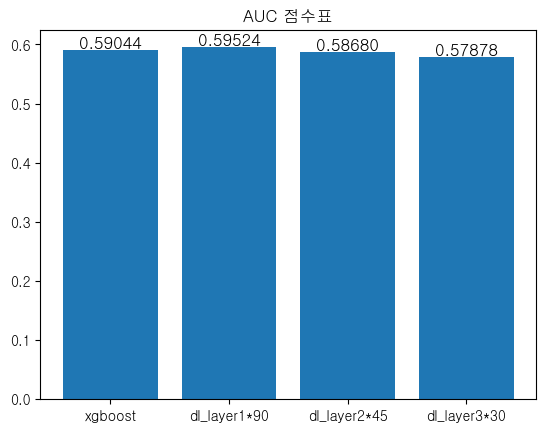

In [22]:
import matplotlib.pyplot as plt

x = np.arange(4)
methods = ['xgboost', 'dl_layer1*90', 'dl_layer2*45', 'dl_layer3*30']
values = [auc_score_b, auc_score_d1, auc_score_d2, auc_score_d3]
# values = [100, 200, 300, 400]

plt.rcParams['font.family'] = 'Gulim'

plt.title('AUC 점수표')
bar = plt.bar(x, values)
plt.xticks(x, methods)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.5f' % height, ha='center', va='bottom', size = 12)

plt.show() # ephoc 20회

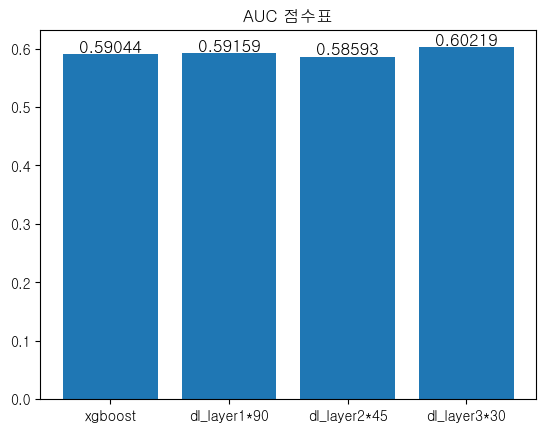

In [24]:
from IPython.display import Image
Image("output_ephocs10.png") # ephoc 10회

4. 완성하지 못한 부분에 대하여 "한계점과 추후 해결 방안을 알맞게 작성하였는가?"
- 완성하지 못한 부분은 특별히 없으나 굳이 고려하자면, AUC 점수가 너무 낮게 나온 점이 아닌가 생각합니다. 이것은 기본적으로 이전 전처리에서 일부 null값을 평균으로 적당히 넣은 부작용일 수도 있고(그런 전처리를 하는 소스를 본 기억이 있습니다.) 최초 값이 잘못되어 올라왔을 가능성도 있습니다. 아마 모델 자체로는, 패러미터를 더 다변화하여 서치를 진행하면 좋은 값을 찾을 수 있을 지도 모릅니다. 좋은 값이 나온 결과의 모델들을 참고할 필요가 있습니다.